Import libraries

In [69]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# packages for hyperparameters tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from hsml.schema import Schema
from hsml.model_schema import ModelSchema

import os

import hopsworks

In [70]:
project = hopsworks.login()

fs = project.get_feature_store()

2025-01-07 22:43:46,048 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-07 22:43:46,058 INFO: Initializing external client
2025-01-07 22:43:46,059 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-07 22:43:47,830 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1149079


In [71]:
news_propagation_fg = fs.get_feature_group(
    name="news_propagation",
    version=1,
)

In [72]:
selected_features = news_propagation_fg.select_except(["news_id"])

In [73]:
selected_features.show(5)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.79s) 


,average_followers,average_follows,repost_total,post_total,repost_percentage,average_repost,average_favorite,label,news_lifetime,nb_users_10_hours,average_time_difference,retweet_percentage_1_hour
0,625.000000,438.000000,0,1,0.000000,0.000000,0.000000,1,0,1,0.0,1.000000
1,1410.833333,1103.416667,4,10,0.285714,0.285714,6.166667,0,63372,1,0.0,0.071429
2,536.454545,342.909091,979,1,0.998980,9.989796,499.000000,0,0,1,0.0,0.001020
3,223066.000000,178.000000,0,2,0.000000,0.000000,0.000000,0,39416,1,0.0,0.500000
4,74.500000,156.000000,0,2,0.000000,0.000000,0.000000,0,11319,1,0.0,0.500000


In [74]:
feature_view = fs.get_or_create_feature_view(
        name = 'news_propagation_feature_views',
        version = 1,
        labels=["label"],
        query=selected_features,
)

In [75]:
# Split data into training, validation, and test sets
X_train, X_val, X_test, y_train, y_val, y_test = feature_view.train_validation_test_split(
    validation_size=0.2,
    test_size=0.1,
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.77s) 


In [76]:
param = {'max_depth': 2, 'eta': 0.7, 'objective': 'binary:logistic'}
param = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.5, 'objective': 'binary:logistic'}

In [ ]:
num_round = 10
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

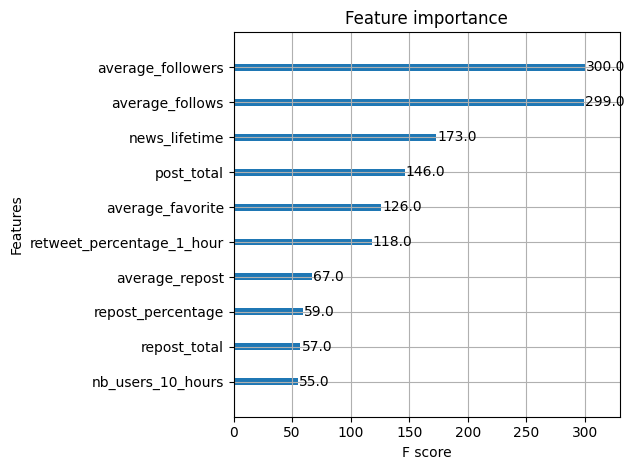

In [ ]:
images_dir = 'figures'
fig = xgb.plot_importance(clf)
fig.figure.tight_layout()
fig.figure.savefig(os.path.join(images_dir, "feature_importance.png"))

In [ ]:
y_pred_train = clf.predict(X_train)
accuracy_score(y_train, y_pred_train)

1.0

In [56]:
y_pred_test = clf.predict(X_test)

In [57]:
accuracy_score(y_test, y_pred_test)

0.7192982456140351

In [58]:
# Generate the confusion matrix using the true labels (y_test) and predicted labels (y_pred_test)
results = confusion_matrix(y_test, y_pred_test)

# Print the confusion matrix
print(results)

[[18  9]
 [ 7 23]]


In [59]:
# Create a DataFrame from the confusion matrix results
df_cm = pd.DataFrame(
    results, 
    ['True Real', 'True Fake'],
    ['Pred Real', 'Pred Fake']
)

# Create and save the confusion matrix heatmap
plt.figure(figsize=(8, 6))
cm = sns.heatmap(
    df_cm, 
    annot=True,
    fmt='d',                 # Use integer format for numbers
    cmap='RdPu',             # Use a color palette that works well for binary classification
    annot_kws={'size': 12},  # Increase annotation text size
    cbar=True                # Include color bar
)

# Add title and labels
plt.title('Confusion Matrix for Fake News Detection')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Adjust layout and save
plt.tight_layout()
plt.savefig(os.path.join(images_dir, "confusion_matrix.png"), dpi=300, bbox_inches='tight')
plt.close()

In [60]:
metrics = {
    "accuracy": accuracy_score(y_test, y_pred_test)
}
metrics

{'accuracy': 0.7192982456140351}

Hyperpameters tuning

In [61]:
tuning = True

In [ ]:
# Define the hyperparameter grid
if tuning:
    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.01, 0.001],
        'subsample': [0.5, 0.7, 1],
        "n_estimators": [100, 200, 300]
    }

    # Create the XGBoost model object
    xgb_model = xgb.XGBClassifier()

    # Create the GridSearchCV object
    grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')

    # Fit the GridSearchCV object to the training data
    grid_search.fit(X_train, y_train)

    # Print the best set of hyperparameters and the corresponding score
    print("Best set of hyperparameters: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.5}
Best score:  0.689029535864979


In [63]:
# Define the hyperparameter distributions
if tuning:
    param_dist = {
        'max_depth': stats.randint(3, 10),
        'learning_rate': stats.uniform(0.01, 0.1),
        'subsample': stats.uniform(0.5, 0.5),
        'n_estimators':stats.randint(50, 200)
    }

    # Create the XGBoost model object
    xgb_model = xgb.XGBClassifier()

    # Create the RandomizedSearchCV object
    random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy')

    # Fit the RandomizedSearchCV object to the training data
    random_search.fit(X_train, y_train)

    # Print the best set of hyperparameters and the corresponding score
    print("Best set of hyperparameters: ", random_search.best_params_)
    print("Best score: ", random_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.04726763669768636, 'max_depth': 8, 'n_estimators': 150, 'subsample': 0.5099843392917275}
Best score:  0.6890944498539435


Save the model into Hopsworks

In [64]:
# Get the model registry
mr = project.get_model_registry()

In [65]:
# Create input schema using X_train
input_schema = Schema(X_train)

# Create output schema using y_train
output_schema = Schema(y_train)

# Create a ModelSchema object specifying the input and output schemas
model_schema = ModelSchema(
    input_schema=input_schema, 
    output_schema=output_schema,
)

# Convert the model schema to a dictionary
model_schema.to_dict()# Specify the directory where the model files will be saved
model_dir = "news_propagation_model"

# Check if the directory exists, and create it if it doesn't
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

# Save the trained classifier as json file
clf.save_model(model_dir + "/model.json")

In [66]:
# Create a model in the model registry
model = mr.python.create_model(
    name="news_propagation_model",
    description="News Propagation Model",
    input_example=X_train.sample(),
    model_schema=model_schema,
    feature_view=feature_view,
    metrics=metrics,
)

# Save the model to the specified directory
model.save(model_dir)

Uploading: 100.000%|██████████| 207185/207185 elapsed<00:02 remaining<00:00  1.24it/s]
Uploading: 100.000%|██████████| 127/127 elapsed<00:01 remaining<00:00<00:07,  1.86s/it]
Uploading: 100.000%|██████████| 1100/1100 elapsed<00:01 remaining<00:00
Model export complete: 100%|██████████| 6/6 [00:12<00:00,  2.16s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/1149079/models/news_propagation_model/12


Model(name: 'news_propagation_model', version: 12)